# ML for cybersecurity - Exploration

## Project objectives

The goal of the project is to design, deploy and evaluate a data chain for the analysis of
cybersecurity data. The data treatment will be performed as batch.

This notebook will be used to explore the data and try to find some interesting insights.

### Data description

This paper presents a dataset to support researchers in the validation process of solutions such
as Intrusion Detection Systems (IDS) based on artificial intelligence and machine learning techniques for
the detection and categorization of threats in Cyber Physical Systems (CPS). To this end, data were acquired
from a hardware-in-the-loop Water Distribution Testbed (WDT) which emulates water flowing between eight
tanks via solenoid-valves, pumps, pressure and flow sensors. The testbed is composed of a real subsystem
that is virtually connected to a simulated one. The proposed dataset encompasses both physical and network
data in order to highlight the consequences of attacks in the physical process as well as in network traffic
behaviour. Simulations data are organized in four different acquisitions for a total duration of 2 hours by
considering normal scenario and multiple anomalies due to cyber and physical attacks.

### Importing libraries

In [1]:
from preprocess_data import get_HITL, clean_HITL
import pandas as pd
import matplotlib.pyplot as plt

random_state = 42


### Loading data

As both types of datasets have different structures, we will load them separately.

In [2]:
hitl_dict = get_HITL("../../data/HardwareInTheLoop/", small=True)
df_network, df_physical = clean_HITL(hitl_dict) # Clean-up helper function

print("Network dataset shape: ", df_network.shape)
print("Physical dataset shape: ", df_physical.shape)

Network dataset shape:  (243065, 17)
Physical dataset shape:  (91, 44)


## Network dataset exploration

In [3]:
df_network.head()

,time,mac_s,mac_d,ip_s,ip_d,sport,dport,proto,flags,size,modbus_fn,n_pkt_src,n_pkt_dst,modbus_response,label_n,label,attack
0,1.617993e+09,74:46:a0:bd:a7:1b,e6:3f:ac:c9:a8:8c,84.3.251.20,84.3.251.101,56666.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,NaN,0,normal,1
1,1.617993e+09,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,502.0,56666.0,Modbus,11000.0,64,Read Coils Response,15.0,50.0,[0],0,normal,1
2,1.617993e+09,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,56668.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,NaN,0,normal,1
3,1.617993e+09,fa:00:bc:90:d7:fa,74:46:a0:bd:a7:1b,84.3.251.103,84.3.251.20,502.0,56668.0,Modbus,11000.0,65,Read Holding Registers Response,15.0,50.0,[0],0,normal,1
4,1.617993e+09,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,502.0,56666.0,Modbus,11000.0,65,Read Holding Registers Response,15.0,50.0,[0],0,normal,1


In [4]:
df_network.columns

Index(['time', 'mac_s', 'mac_d', 'ip_s', 'ip_d', 'sport', 'dport', 'proto',
       'flags', 'size', 'modbus_fn', 'n_pkt_src', 'n_pkt_dst',
       'modbus_response', 'label_n', 'label', 'attack'],
      dtype='object')

The `attack` column come from the cleanup of the dataset to differentiate between normal and attack datasets.


Dtypes of the columns:

In [5]:
df_network.dtypes

time               float64
mac_s               object
mac_d               object
ip_s                object
ip_d                object
sport              float64
dport              float64
proto               object
flags              float64
size                 int64
modbus_fn           object
n_pkt_src          float64
n_pkt_dst          float64
modbus_response     object
label_n              int64
label               object
attack               int64
dtype: object

Let's look at the proportion of nan values per column:

In [20]:
df_network.isna().sum() / df_network.shape[0] * 100

time                0.000000
mac_s               0.000000
mac_d               0.000000
ip_s                0.003703
ip_d                0.003703
sport              14.194146
dport              14.194146
proto               0.000000
flags              14.194146
size                0.000000
modbus_fn          16.644108
n_pkt_src           0.003703
n_pkt_dst           0.003703
modbus_response    58.290169
attack              0.000000
dtype: float64

`modbus_response` is made out of more than half of nan values, trying to remove this column later on might be a good idea to reduce the dimensionality of the dataset.

`sport`, `dport` and `flags` are all numerical columns so we can interpolate some values to fill the nan values later on. Theses columns seem to be interesting to play with/without to see how they impact the model.

A PCA could be interesting to reduce the dimensionality of the dataset as 5 columns contain lots of nan values.

### Labels

Let's take a quick detour to see what are the labels like.

In [6]:
network_dataset_labels = df_network[["label_n", "label"]]
df_network = df_network.drop(columns=["label_n", "label"])

In [7]:
network_dataset_labels.head(3)

,label_n,label
0,0,normal
1,0,normal
2,0,normal


In [8]:
network_dataset_labels["label_n"].value_counts()

label_n
0    176087
1     66978
Name: count, dtype: int64

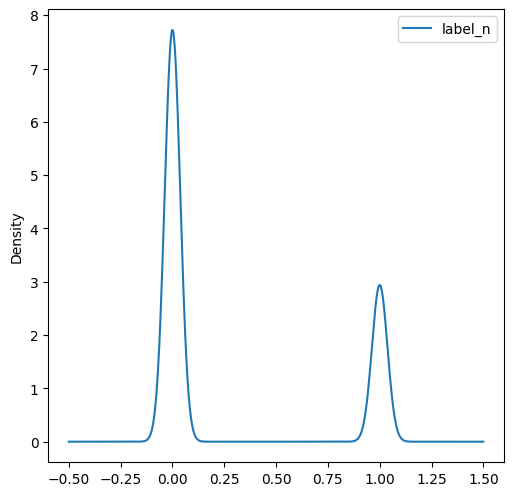

In [29]:
network_dataset_labels.plot(kind='density', subplots=True, layout=(3,3), sharex=False, figsize=(20, 20))
plt.show()

Our dataset is unbalanced, the ratio seems to be 1/3.

In [9]:
network_dataset_labels["label"].value_counts()

label
normal            176087
DoS                37665
MITM               16841
physical fault     12469
anomaly                3
Name: count, dtype: int64

We have 5 labels: normal, DoS, MITM, physical fault, anomaly.
More imporantly the data is also split is normal (label_n=0) or not normal (label_n=1).

### Features

__Numbers columns:__


In [10]:
network_number_cols = df_network.select_dtypes(include=['number']).columns.values.tolist()
network_number_cols

['time', 'sport', 'dport', 'flags', 'size', 'n_pkt_src', 'n_pkt_dst', 'attack']

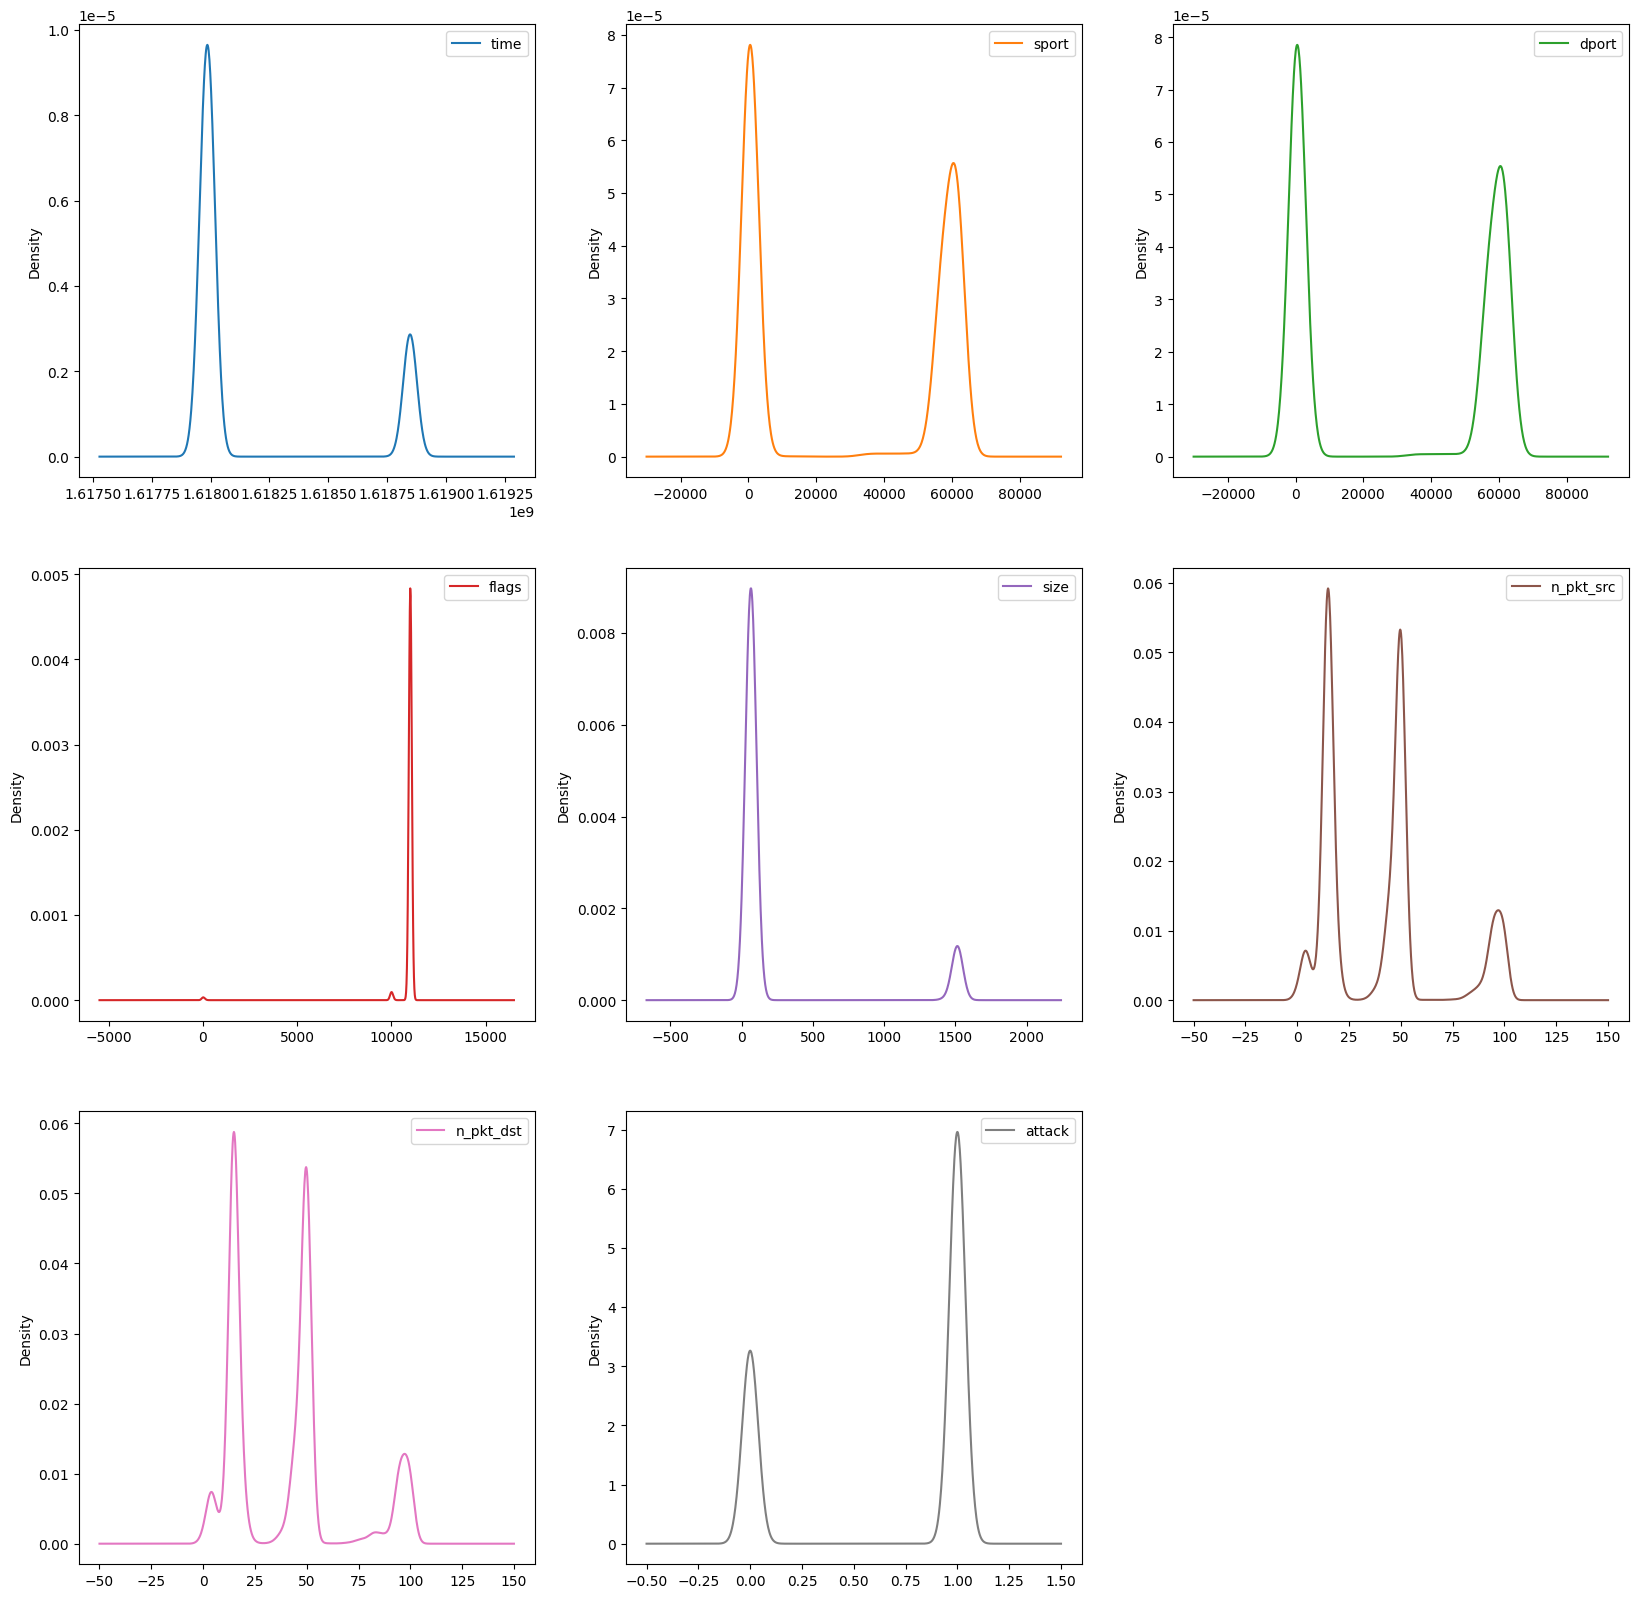

In [11]:
df_network.plot(kind='density', subplots=True, layout=(3,3), sharex=False, figsize=(20, 20))
plt.show()

Let's quickly analyse the density of the numerical columns:
- `sport` and `dport`: two density spikes around 0 and 60000
- `flags`: a huge spike around 11000 and very few data around 10000 and 0
- `size`: two main spikes, the first one around 60 and the second one is around 1500, but 10x less dense
- `n_pkt_src` and `n_pkt_dst`: closer data with more dominant spikes, the two main ones are around 15 and 50
- `label_n`: 0 or 1, 1 is 2.5x less dense so we have a class imbalance
- `attack`: 0 or 1, the normal dataset (0) is half as dense as the three attack datasets (1) combined

In [21]:
df_network.describe()

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst,attack
count,2.430650e+05,208564.000000,208564.000000,208564.000000,243065.000000,243056.000000,243056.000000,243065.000000
mean,1.618168e+09,29935.053614,29827.705903,10902.935909,236.671434,39.752514,39.561961,0.680859
std,3.528267e+05,29495.006844,29513.480383,928.439179,467.620917,28.052526,27.835061,0.466145
min,1.617968e+09,502.000000,502.000000,10.000000,60.000000,0.000000,0.000000,0.000000
25%,1.617971e+09,502.000000,502.000000,11000.000000,65.000000,15.000000,15.000000,0.000000
50%,1.617995e+09,33321.000000,502.000000,11000.000000,66.000000,44.000000,44.000000,1.000000
75%,1.617998e+09,61317.000000,61317.000000,11000.000000,66.000000,50.000000,50.000000,1.000000
max,1.618849e+09,61646.000000,61646.000000,11000.000000,1514.000000,100.000000,100.000000,1.000000


Let's quickly analyse this:
- `n_pkt` columns range from 0 to a 100. Combined to what we saw on the density plot, we might be able to cluster them and reduce the dimensionality of the dataset.
- `flags` flags has a median of 10902 which is extremely close of the max value (which represents most of the density).
- `ports` look the same (density wise and range wise) but on a different scale. We might be able to cluster them as well.


__Object columns:__


In [12]:
network_categorical_cols = df_network.select_dtypes(include=['object']).columns.values.tolist()
network_categorical_cols

['mac_s', 'mac_d', 'ip_s', 'ip_d', 'proto', 'modbus_fn', 'modbus_response']

Let's look at the distribution of the object columns:

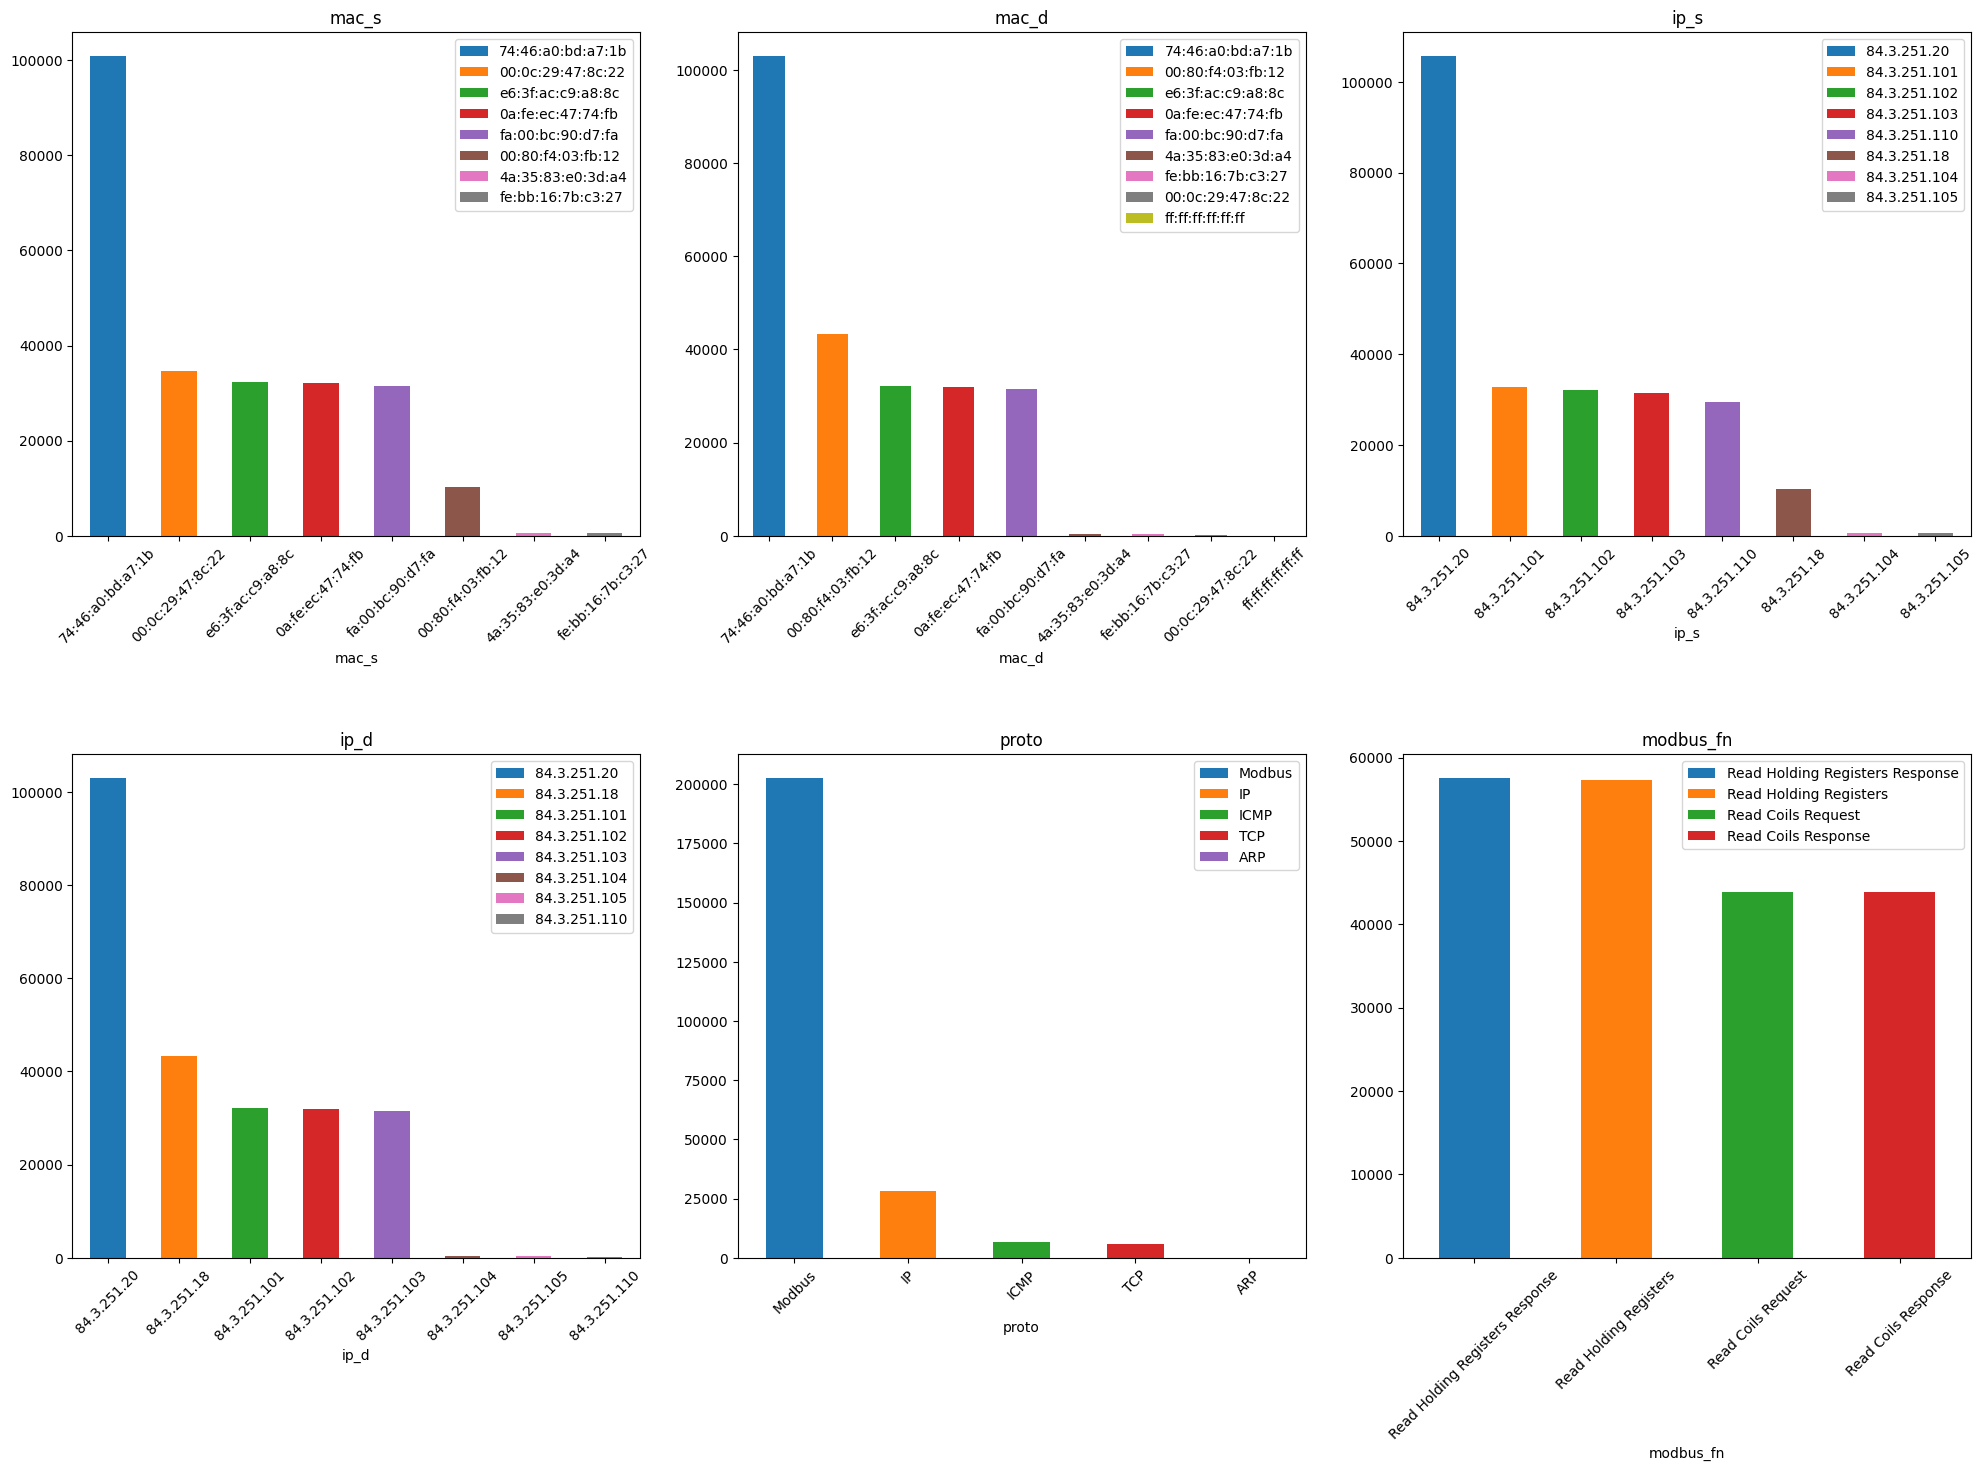

In [61]:
cols = [col for col in network_categorical_cols if col not in ["modbus_response", "Time"]]

fig = plt.figure(figsize=(20, 20))
for i, col in enumerate(cols):
    ax = fig.add_subplot(3, 3, i+1)
    value_count = df_network[col].value_counts()
    lines = value_count.plot(kind='bar', ax=ax, title=col)
    for j, patch in enumerate(ax.patches):
        patch.set_facecolor(f"C{j}")
        patch.set_label(value_count.index[j])
    ax.legend(handles=ax.patches)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
fig.tight_layout()
plt.show()


It is hard to deduce anything from the distributions, but we make the following observations:
- the distribution of `mac_s`, `mac_d`, `ip_s` and `ip_d` are very similar: one address is more frequent than the 7 others
- the distribution of `proto` is very unbalanced, with the "Modbus" protocol being 10x more frequent than the others. This column might be irrelevant for the classification
- the distribution of `label` is very unbalanced, but this is expected since we have merged all the attacks datasets with the normal one. Regarding the type of anomalies, there is 2x more "DoS" than "MITM" and "physical fault".
- the `modbus_response` data is very balanced between the 4 values.

We can see that most of our categorical features have <10 unique values.

In [62]:
def get_hist_pairs_per_column(dataset, col_name_1, col_name_2):
    # Sum each identical pair of ip addresses
    ip_pairs_count = {}
    for i, row in dataset.iterrows():
        ip_pair = (row[col_name_1], row[col_name_2])
        if ip_pair in ip_pairs_count:
            ip_pairs_count[ip_pair] += 1
        else:
            ip_pairs_count[ip_pair] = 1

    # Numerize each pair to print it on a graph
    ip_pairs_count_numerized = {}
    for i, (key, value) in enumerate(ip_pairs_count.items()):
        ip_pairs_count_numerized[i] = value

    # Plot the histogram
    plt.bar(ip_pairs_count_numerized.keys(), ip_pairs_count_numerized.values())

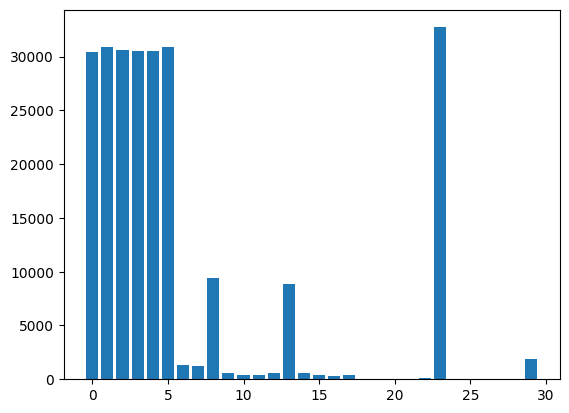

In [65]:
get_hist_pairs_per_column(df_network, "mac_s", "mac_d")

We have around 30 pairs of (mac_s, mac_d) that are unique. There are mostly 7-9 pairs that are mostly used.

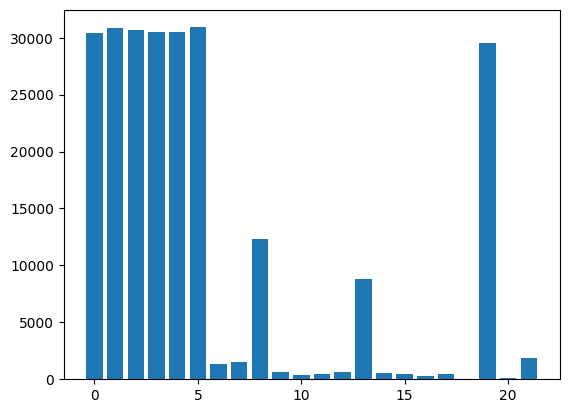

In [66]:
get_hist_pairs_per_column(df_network, "ip_s", "ip_d")

We have around 21 pairs of (ip_s, ip_d) that are unique. The repartition here is also a bit shallow as there are 7-9 pairs that are also mostly used. The repartition of the ip addresses is very similar to the mac addresses.

### Let's try to go a bit deeper and plot the labels as a time series

In [80]:
df_network[network_dataset_labels.columns] = network_dataset_labels

df_network_sorted = df_network.sort_values(by=["time"])
df_network_sorted["time_minute"] = pd.to_datetime(df_network_sorted["time"], unit='s').dt.strftime("%Y-%m-%d %H:%M")
df_network_sorted.head()

,time,mac_s,mac_d,ip_s,ip_d,sport,dport,proto,flags,size,modbus_fn,n_pkt_src,n_pkt_dst,modbus_response,attack,label_n,label,time_minute
165493,1.617968e+09,fa:00:bc:90:d7:fa,74:46:a0:bd:a7:1b,84.3.251.103,84.3.251.20,502.0,61516.0,Modbus,11000.0,65,Read Holding Registers Response,15.0,49.0,[0],0,0,normal,2021-04-09 11:30
165494,1.617968e+09,74:46:a0:bd:a7:1b,0a:fe:ec:47:74:fb,84.3.251.20,84.3.251.102,61517.0,502.0,Modbus,11000.0,66,Read Coils Request,49.0,15.0,NaN,0,0,normal,2021-04-09 11:30
165495,1.617968e+09,fa:00:bc:90:d7:fa,74:46:a0:bd:a7:1b,84.3.251.103,84.3.251.20,502.0,61516.0,Modbus,11000.0,65,Read Holding Registers Response,18.0,43.0,[0],0,0,normal,2021-04-09 11:30
165496,1.617968e+09,0a:fe:ec:47:74:fb,74:46:a0:bd:a7:1b,84.3.251.102,84.3.251.20,502.0,61517.0,Modbus,11000.0,65,Read Holding Registers Response,18.0,44.0,[0],0,0,normal,2021-04-09 11:30
165497,1.617968e+09,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,502.0,61515.0,Modbus,11000.0,64,Read Coils Response,15.0,50.0,[0],0,0,normal,2021-04-09 11:30


In [81]:
df_grouped = df_network_sorted.groupby(["time_minute", 'label_n']).size().unstack().fillna(0)
df_grouped

label_n,0,1
time_minute,,
2021-04-09 11:30,164.0,0.0
2021-04-09 11:31,1365.0,0.0
2021-04-09 11:32,1362.0,0.0
2021-04-09 11:33,1360.0,0.0
2021-04-09 11:34,1360.0,0.0
...,...,...
2021-04-19 16:08,593.0,772.0
2021-04-19 16:09,0.0,1368.0
2021-04-19 16:10,1334.0,30.0


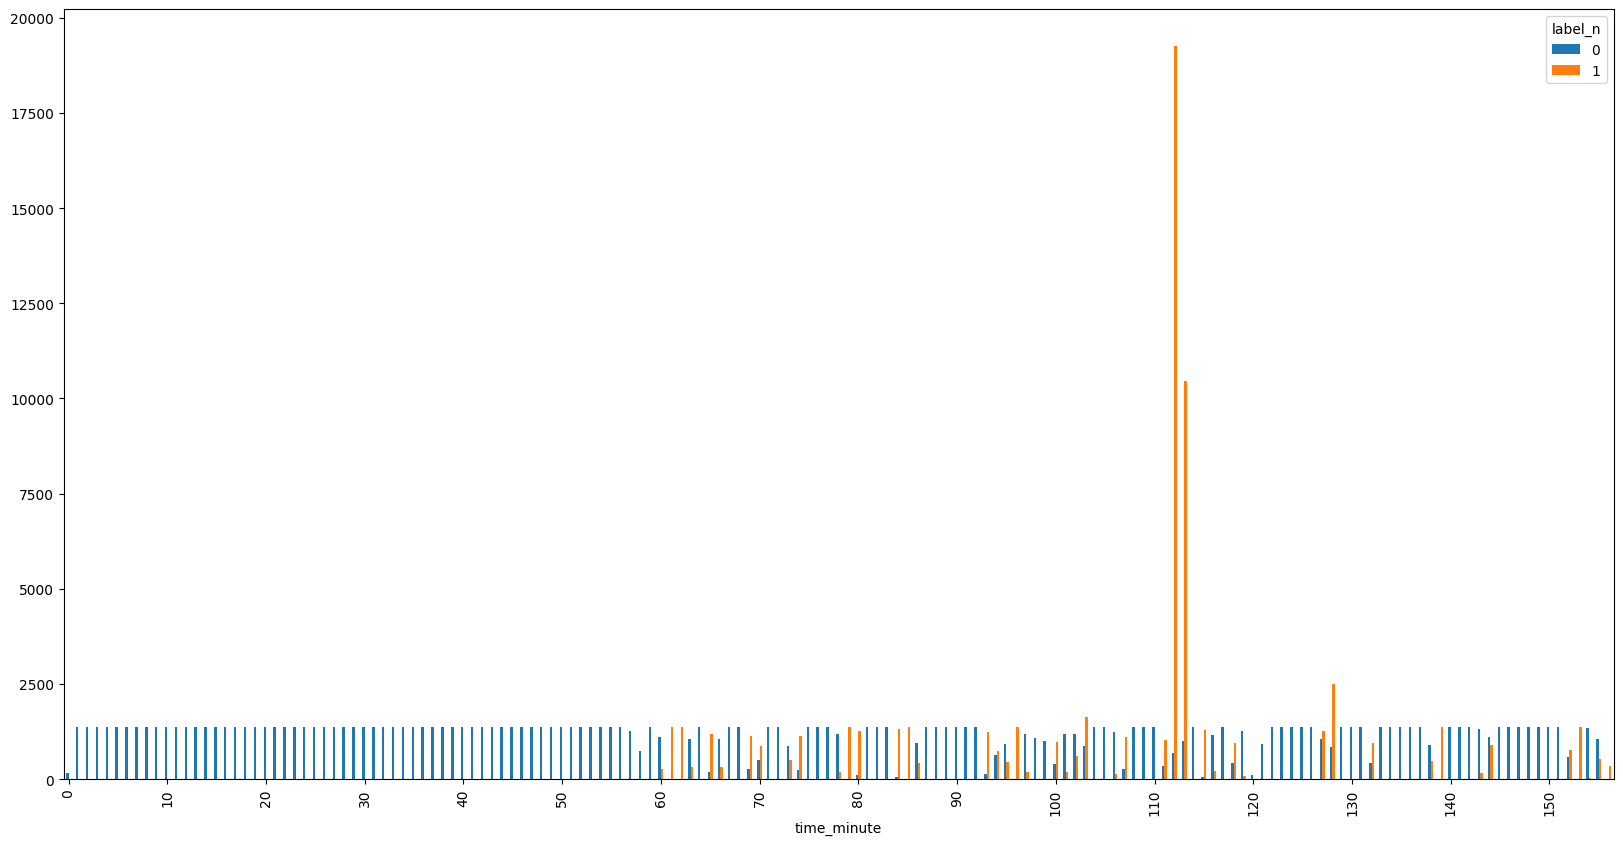

In [104]:
df_grouped.plot(kind='bar', figsize=(20, 10), xticks=range(0, df_grouped.shape[0], 10))
plt.show()

Firstly, let's see the number of anormal data per minute for the "normal" dataset

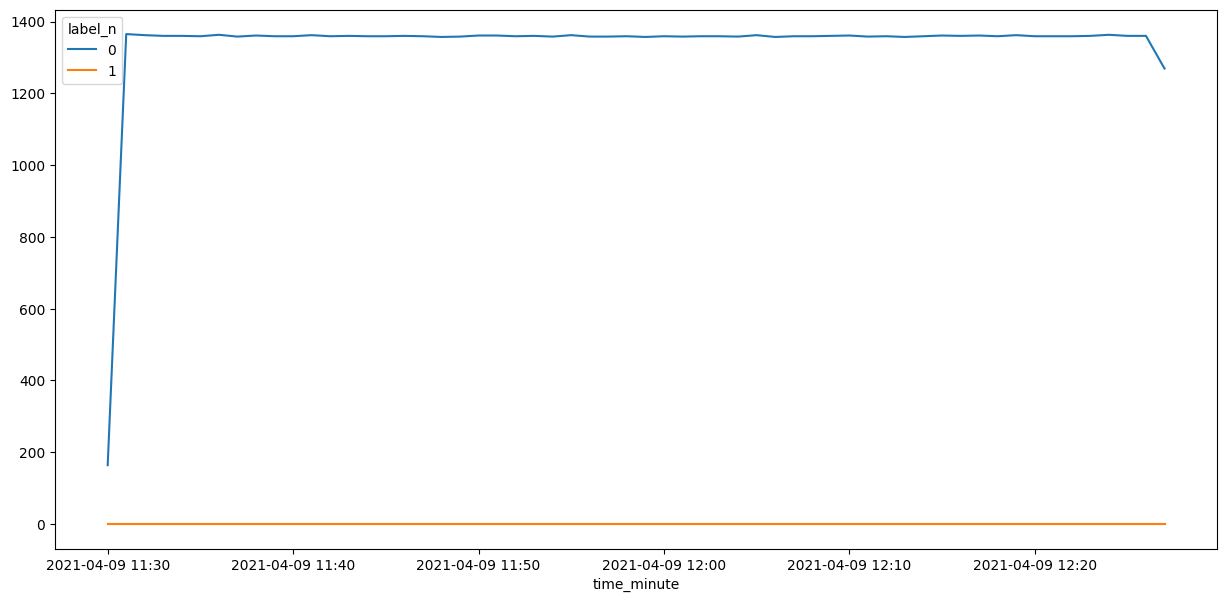

In [82]:
df_grouped.loc["2021-04-09 11":"2021-04-09 13"].plot(figsize=(15, 7))
plt.show()

As expected, there is no 1 label in the normal dataset. Let's check for 2020-04-09 (first day of recorded anomalies)

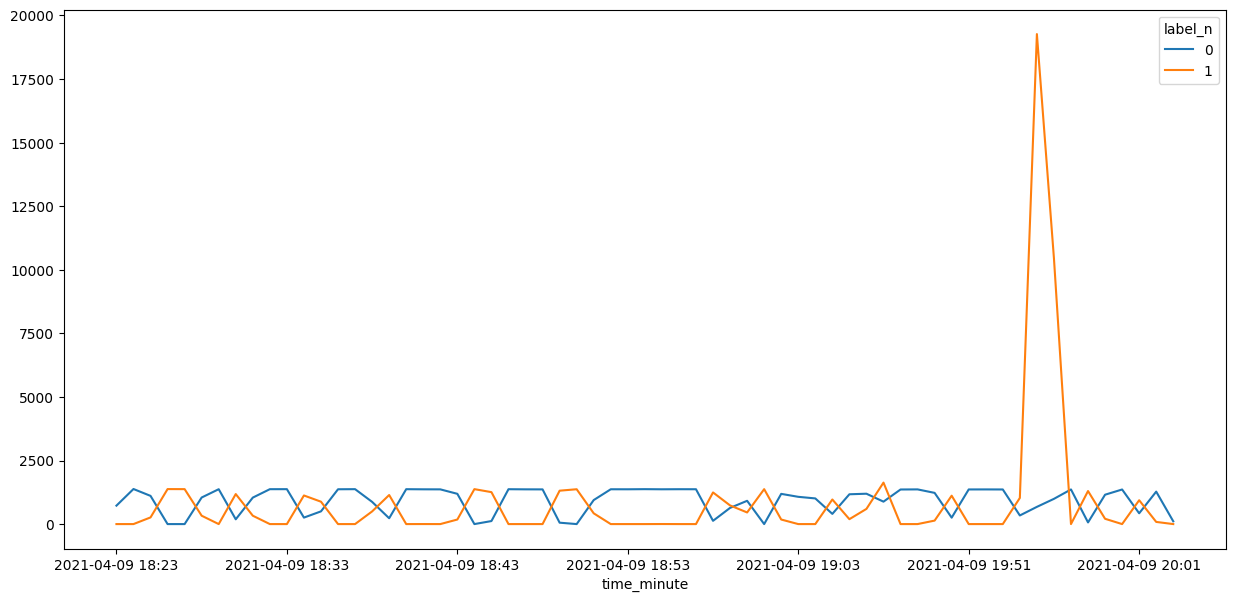

In [83]:
df_grouped.loc["2021-04-09 18":"2021-04-09 22"].plot(figsize=(15, 7))
plt.show()

We see way more fluctuation in the data. There is anormal activity for some time, then it stops, then it starts again with a huge peak

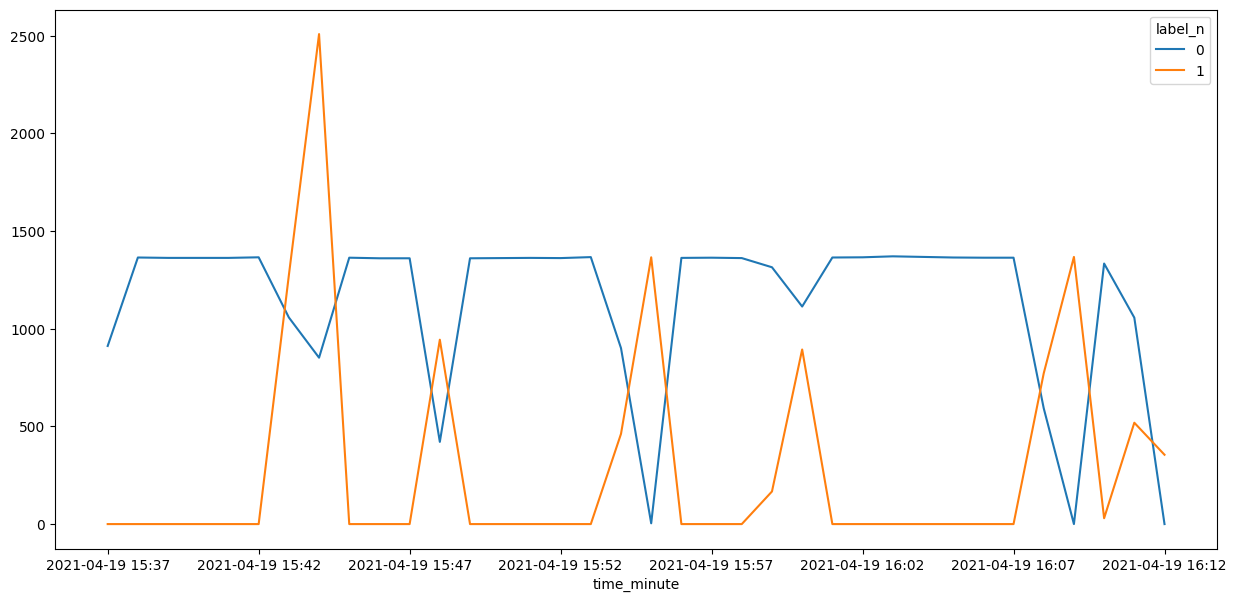

In [84]:
df_grouped.loc["2021-04-19":"2021-04-20"].plot(figsize=(15, 7))
plt.show()

## Physical dataset exploration

In [13]:
df_physical.head()

,time,tank_1,tank_2,tank_3,tank_4,tank_5,tank_6,tank_7,tank_8,pump_1,...,valv_16,valv_17,valv_18,valv_19,valv_20,valv_21,valv_22,label_n,label,attack
0,1.630780e+09,1501,1844,306,0,522,0,0,0,False,...,False,True,False,False,False,False,False,0.0,normal,1
1,1.630780e+09,1,552,1180,1054,486,329,0,0,False,...,False,True,False,False,True,False,False,1.0,MITM,1
2,1.630780e+09,671,3,360,24,0,703,112,0,False,...,False,False,False,False,False,False,False,0.0,normal,1
3,1.630780e+09,1167,1922,112,24,805,20,458,337,False,...,False,True,False,False,False,False,False,0.0,normal,1
4,1.630780e+09,1,4,1632,785,423,6,458,402,False,...,False,False,False,False,True,False,False,0.0,normal,1
